In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [4]:
def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

seed = 1337
set_seed(seed)

In [5]:
import os
import sys

notebook_dir = os.getcwd()

root_dir = os.path.abspath(os.path.join(notebook_dir, "../../"))
sys.path.append(root_dir)

In [6]:
from dotenv import load_dotenv

load_dotenv()

from service import EnvironmentSecretService

In [7]:
from core.models.exchange import ExchangeType
from core.models.lookback import Lookback
from core.models.timeframe import Timeframe
from exchange import ExchangeFactory

In [8]:
DEFAULT_EXCHANGE = ExchangeType.BYBIT
DEFAULT_TIMEFRAME = Timeframe.ONE_HOUR
DEFAULT_LOOKBACK = Lookback.SIX_MONTH

from datetime import datetime

today = datetime.now().strftime('%Y-%m-%d')

emb_filename = f'ocean_emb_{today}.npy'
volume_df_filename = f'ocean_ft_{today}.csv'

In [9]:
exchange_factory = ExchangeFactory(EnvironmentSecretService())
exchange = exchange_factory.create(DEFAULT_EXCHANGE)

In [45]:
symbols = exchange.fetch_future_symbols()

data = []
for symbol in symbols:
    try:
        for ohlcv in exchange.fetch_ohlcv(symbol, DEFAULT_TIMEFRAME, DEFAULT_LOOKBACK):
            _timestamp, _open, _high, _low, _close, _volume = ohlcv
            data.append([symbol.name, _timestamp, _open, _high, _low, _close, _volume])
    except Exception as e:
        print(f"Error fetching data for {symbol}: {str(e)}")

symbols_df = pd.DataFrame(data, columns=['Symbol', 'Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
symbols_df['Timestamp'] = pd.to_datetime(symbols_df['Timestamp'], unit='ms')
symbols_df.sort_values(by=['Symbol', 'Timestamp'], inplace=True)

In [46]:
def volume_features(df, mfi_period=14):
    df = df.copy()

    df['Date'] = df['Timestamp'].dt.date

    df['ADV'] = df.groupby(['Symbol', 'Date'])['Volume'].transform('mean')

    df['Typical Price'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['Cumulative Price * Volume'] = df['Typical Price'] * df['Volume']

    df['Cum_Volume'] = df.groupby(['Symbol', 'Date'])['Volume'].cumsum()
    df['Cum_Price_Volume'] = df.groupby(['Symbol', 'Date'])['Cumulative Price * Volume'].cumsum()
    df['VWAP'] = df['Cum_Price_Volume'] / df['Cum_Volume']

    df['Price Change'] = df.groupby(['Symbol', 'Date'])['Close'].diff()

    df['OBV_Sign'] = 0
    df.loc[df['Price Change'] > 0, 'OBV_Sign'] = 1
    df.loc[df['Price Change'] < 0, 'OBV_Sign'] = -1
    df['OBV'] = (df['OBV_Sign'] * df['Volume']).groupby(df['Symbol']).cumsum()

    df['A/D'] = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low']) * df['Volume']
    df['A/D'] = df.groupby(['Symbol', 'Date'])['A/D'].cumsum()

    df['Amihud_Illiquidity'] = df['Price Change'].abs() / df['Volume']
    df['Amihud_Illiquidity'] = df.groupby(['Symbol', 'Date'])['Amihud_Illiquidity'].transform('mean')

    df['Raw Money Flow'] = df['Typical Price'] * df['Volume']

    df['Price Diff'] = df.groupby(['Symbol', 'Date'])['Typical Price'].diff()

    df['Positive Money Flow'] = df['Raw Money Flow'].where(df['Price Diff'] > 0, 0)
    df['Negative Money Flow'] = df['Raw Money Flow'].where(df['Price Diff'] < 0, 0)

    df['Positive Money Flow Sum'] = df.groupby('Symbol')['Positive Money Flow'].transform(lambda x: x.rolling(window=mfi_period).sum())
    df['Negative Money Flow Sum'] = df.groupby('Symbol')['Negative Money Flow'].transform(lambda x: x.rolling(window=mfi_period).sum())
    df['Money Flow Ratio'] = df['Positive Money Flow Sum'] / df['Negative Money Flow Sum']
    df['MFI'] = 100 - (100 / (1 + df['Money Flow Ratio']))

    df['Previous Close'] = df.groupby('Symbol')['Close'].shift(1)
    df['TR1'] = df['High'] - df['Low']
    df['TR2'] = (df['High'] - df['Previous Close']).abs()
    df['TR3'] = (df['Low'] - df['Previous Close']).abs()

    df['True Range'] = df[['TR1', 'TR2', 'TR3']].max(axis=1)

    df['Volume-Weighted_TR'] = df['True Range'] * df['Volume']

    df.drop(columns=[
        'Date', 'Typical Price', 'Cum_Volume', 'Cum_Price_Volume', 'Cumulative Price * Volume',
        'Price Change', 'OBV_Sign', 'Raw Money Flow', 'Price Diff', 'True Range', 'Money Flow Ratio',
        'Positive Money Flow', 'Negative Money Flow', 'Positive Money Flow Sum', 'Negative Money Flow Sum', 'Previous Close',  'TR1', 'TR2', 'TR3'
    ], inplace=True)

    return df

In [47]:
volume_df = volume_features(symbols_df)
volume_df.to_csv(volume_df_filename, index=False)

In [10]:
volume_df = pd.read_csv(volume_df_filename)

In [11]:
volume_df.shape[0]

1566057

In [12]:
volume_df.head()

,Symbol,Timestamp,Open,High,Low,Close,Volume,ADV,VWAP,OBV,A/D,Amihud_Illiquidity,MFI,Volume-Weighted_TR
0,10000000AIDOGEUSDT,2024-03-30 22:00:00,0.005810,0.005842,0.005785,0.005817,14082800.0,1.638490e+07,0.005815,0.0,1.729467e+06,4.816182e-13,NaN,802.7196
1,10000000AIDOGEUSDT,2024-03-30 23:00:00,0.005817,0.005855,0.005797,0.005826,18687000.0,1.638490e+07,0.005821,18687000.0,1.729467e+06,4.816182e-13,NaN,1083.8460
2,10000000AIDOGEUSDT,2024-03-31 00:00:00,0.005826,0.005910,0.005826,0.005856,17636400.0,1.935145e+07,0.005864,18687000.0,-5.038971e+06,1.805443e-12,NaN,1481.4576
3,10000000AIDOGEUSDT,2024-03-31 01:00:00,0.005856,0.005925,0.005828,0.005912,19413600.0,1.935145e+07,0.005877,38100600.0,9.170983e+06,1.805443e-12,NaN,1883.1192
4,10000000AIDOGEUSDT,2024-03-31 02:00:00,0.005912,0.005956,0.005887,0.005930,12319400.0,1.935145e+07,0.005889,50420000.0,1.220620e+07,1.805443e-12,NaN,850.0386


In [13]:
unique_symbol_count = volume_df['Symbol'].nunique()
unique_symbol_count

411

In [14]:
features = ['ADV', 'VWAP', 'OBV', 'Amihud_Illiquidity']

n_features = len(features)

print("N Features: ", n_features)

N Features:  4


In [15]:
print("NaN values before imputation:\n", volume_df.isna().sum())

imputer = SimpleImputer(strategy='mean')

volume_df[features] = imputer.fit_transform(volume_df[features])

print("NaN values after imputation:\n", volume_df.isna().sum())

symbols = volume_df['Symbol'].unique()

symbol_sequences = []

for symbol in symbols:
    symbol_data = volume_df[volume_df['Symbol'] == symbol][features].to_numpy()
    symbol_sequences.append(symbol_data)

sequence_lengths = [len(seq) for seq in symbol_sequences]

print("Lengths of each sequence:", sequence_lengths)

max_sequence_length = max([len(seq) for seq in symbol_sequences])

print("Max seq:", max_sequence_length)

padded_sequences = [
    np.pad(seq, ((max_sequence_length - len(seq), 0), (0, 0)), 'constant', constant_values=0)
    for seq in symbol_sequences
]

pad_sequence_lengths = [len(seq) for seq in padded_sequences]

print("Lengths of each pad sequence:", pad_sequence_lengths)

symbol_sequences = np.array(padded_sequences)

scaler = StandardScaler()
n_symbols, t_time_steps, n_features = symbol_sequences.shape
symbol_sequences = symbol_sequences.reshape(-1, n_features)
normalized_sequences = scaler.fit_transform(symbol_sequences)
normalized_sequences = normalized_sequences.reshape(n_symbols, t_time_steps, n_features)

print("Shape of features:", normalized_sequences.shape)

X = torch.tensor(normalized_sequences, dtype=torch.float32)

X = X.view(X.size(0), -1)

print("X shape", X.shape)

NaN values before imputation:
 Symbol                   0
Timestamp                0
Open                     0
High                     0
Low                      0
Close                    0
Volume                   0
ADV                      0
VWAP                     9
OBV                      0
A/D                    265
Amihud_Illiquidity       0
MFI                   5343
Volume-Weighted_TR       0
dtype: int64
NaN values after imputation:
 Symbol                   0
Timestamp                0
Open                     0
High                     0
Low                      0
Close                    0
Volume                   0
ADV                      0
VWAP                     0
OBV                      0
A/D                    265
Amihud_Illiquidity       0
MFI                   5343
Volume-Weighted_TR       0
dtype: int64
Lengths of each sequence: [4320, 2577, 3198, 2028, 4320, 4320, 4320, 4320, 2363, 2844, 4320, 4320, 323, 4320, 4320, 84, 251, 4320, 4320, 4320, 4320, 4320, 43

In [16]:
class Autoencoder(nn.Module):
    def __init__(self, feature_dim, latent_dim=32, dropout_prob=0.2):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(dropout_prob),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(64, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(dropout_prob),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(128, feature_dim),
            nn.Tanh()
        )

        self.residual = nn.Linear(feature_dim, feature_dim)

    def forward(self, x):
        encoded = self.encoder(x)

        decoded = self.decoder(encoded)

        residual_output = self.residual(x)

        output = decoded + residual_output

        return output

    def get_latent(self, x, normalize=True):
        latent = self.encoder(x)

        if normalize:
            latent = F.normalize(latent, p=2, dim=1)

        return latent

In [31]:
import os

import torch


class SnapshotManager:
    def __init__(self, model, snapshot_dir='snapshots', n_snapshots=5, remove_threshold=2):
        self.model = model
        self.model_name = model.__class__.__name__
        self.snapshot_dir = snapshot_dir
        self.n_snapshots = n_snapshots
        self.remove_threshold = remove_threshold

        os.makedirs(self.snapshot_dir, exist_ok=True)

    def save(self, epoch, improved=False):
        snapshot_type = "improved" if improved else "periodic"
        snapshot_path = os.path.join(self.snapshot_dir, f'{self.model_name}_epoch_{epoch + 1}_{snapshot_type}.pth')
        torch.save(self.model.state_dict(), snapshot_path)
        print(f"Saved {snapshot_type} snapshot: {snapshot_path}")

        self._manage_snapshots()

    def load_latest(self):
        snapshots = self._get_sorted_snapshots()
        improved_snapshots = [s for s in snapshots if 'improved' in s and s.startswith(self.model_name)]
        periodic_snapshots = [s for s in snapshots if 'periodic' in s and s.startswith(self.model_name)]

        if improved_snapshots:
            self._load_snapshot(improved_snapshots[-1])
        elif periodic_snapshots:
            self._load_snapshot(periodic_snapshots[-1])
        else:
            print("No snapshots found, starting from scratch.")

    def _load_snapshot(self, snapshot_file):
        snapshot_path = os.path.join(self.snapshot_dir, snapshot_file)

        if os.path.exists(snapshot_path):
            self.model.load_state_dict(torch.load(snapshot_path, map_location='cpu', weights_only=True))
            print(f"Loaded snapshot: {snapshot_path}")
        else:
            print(f"Snapshot {snapshot_path} not found.")

    def _manage_snapshots(self):
        all_snapshots = self._get_sorted_snapshots()
        improved_snapshots = [s for s in all_snapshots if 'improved' in s]
        periodic_snapshots = [s for s in all_snapshots if 'periodic' in s]

        if len(all_snapshots) > self.n_snapshots:
            if len(improved_snapshots) > self.remove_threshold:
                snapshots_to_remove = improved_snapshots[:-1]
                for snapshot in snapshots_to_remove:
                    snapshot_path = os.path.join(self.snapshot_dir, snapshot)
                    if os.path.exists(snapshot_path):
                        os.remove(snapshot_path)
                        print(f"Removed old improved snapshot: {snapshot_path}")

            if len(periodic_snapshots) > self.remove_threshold:
                snapshots_to_remove = periodic_snapshots[:-1]
                for snapshot in snapshots_to_remove:
                    snapshot_path = os.path.join(self.snapshot_dir, snapshot)
                    if os.path.exists(snapshot_path):
                        os.remove(snapshot_path)
                        print(f"Removed old periodic snapshot: {snapshot_path}")

            all_snapshots = self._get_sorted_snapshots()
            if len(all_snapshots) > self.n_snapshots:
                excess_snapshots = all_snapshots[:-self.n_snapshots]
                for snapshot in excess_snapshots:
                    snapshot_path = os.path.join(self.snapshot_dir, snapshot)
                    if os.path.exists(snapshot_path):
                        os.remove(snapshot_path)
                        print(f"Removed excess snapshot: {snapshot_path}")

    def _get_sorted_snapshots(self):
        snapshots = [f for f in os.listdir(self.snapshot_dir) if f.startswith(self.model_name)]
        snapshots.sort(key=lambda s: os.path.getctime(os.path.join(self.snapshot_dir, s)))
        return snapshots


In [38]:
class EarlyStop:
    def __init__(self, patience=5):
        self.patience = patience
        self.best_loss = float('inf')
        self.epochs_without_improvement = 0

    def check(self, current_loss: float):
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.epochs_without_improvement = 0
            return False
        else:
            self.epochs_without_improvement += 1
            if self.epochs_without_improvement >= self.patience:
                print("Early stopping triggered!")
                return True
            return False

class Checkpoints:
    def __init__(self, snapshot_manager, snapshot_interval=5):
        self.snapshot_manager = snapshot_manager
        self.snapshot_interval = snapshot_interval

    def load_latest(self):
        self.snapshot_manager.load_latest()

    def check_and_save(self, epoch: int, improved=False):
        self.snapshot_manager.save(epoch, improved=improved)

    def periodic_save(self, epoch: int):
        if (epoch + 1) % self.snapshot_interval == 0:
            self.snapshot_manager.save(epoch, improved=False)

In [47]:
class Trainer:
    def __init__(self, model, dataloader, early_stop, checkpoint,
                 epochs=50, lr=1e-4, device=None, optimizer_class=torch.optim.Adam,
                 criterion_class=nn.MSELoss, **optimizer_kwargs):

        self.model = model
        self.model_name = model.__class__.__name__
        self.dataloader = dataloader
        self.epochs = epochs
        self.lr = lr
        self.device = device if device else (torch.device("mps") if torch.backends.mps.is_available() else "cpu")
        self.early_stop = early_stop
        self.checkpoint = checkpoint


        self.optimizer = optimizer_class(self.model.parameters(), lr=self.lr, **optimizer_kwargs)
        self.criterion = criterion_class()

        self.checkpoint.load_latest()

    def train(self):
        self.model.to(self.device)
        self.model.train()

        float('inf')

        for epoch in range(self.epochs):
            running_loss = 0.0

            for _batch_idx, (data,) in enumerate(self.dataloader):
                data = data.to(self.device)

                self.optimizer.zero_grad()

                outputs = self.model(data)
                loss = self.criterion(outputs, data)

                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

            avg_train_loss = running_loss / len(self.dataloader)

            print(f"Epoch [{epoch + 1}/{self.epochs}], Train Loss: {avg_train_loss:.8f}")

            improved = avg_train_loss < self.early_stop.best_loss

            self.checkpoint.check_and_save(epoch, improved)

            if self.early_stop.check(avg_train_loss):
                break

            self.checkpoint.periodic_save(epoch)

        print("Training Complete")

In [44]:
def extract_embeddings(model, dataloader, device=None):
    if device is None:
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    model.to(device)

    model.eval()

    embeddings = []

    with torch.no_grad():
        for _batch_idx, (data,) in enumerate(dataloader):
            data = data.to(device)

            latent = model.get_latent(data)

            embeddings.append(latent.cpu())

    embeddings = torch.vstack(embeddings)

    return embeddings

In [65]:
feature_dim = max_sequence_length * n_features
latent_dim = 16
patience = 12
epochs = 900
lr=1e-9
batch_size = 4
n_snapshots = 3

print("Feature DIM: ", feature_dim)

model = Autoencoder(feature_dim=feature_dim, latent_dim=latent_dim)
dataset = torch.utils.data.TensorDataset(X)
dataloader = torch.utils.data.DataLoader(dataset, pin_memory=True, batch_size=batch_size, shuffle=True)

snapshot_manager = SnapshotManager(model, n_snapshots=n_snapshots)
early_stop = EarlyStop(patience=5)
checkpoint = Checkpoints(snapshot_manager=snapshot_manager, snapshot_interval=5)

trainer = Trainer(model, dataloader, early_stop, checkpoint, epochs, lr)

if torch.backends.mps.is_available():
    torch.mps.empty_cache()

trainer.train()

Feature DIM:  17280
Loaded snapshot: snapshots/Autoencoder_epoch_3_improved.pth
Epoch [1/900], Train Loss: 0.03873809
Saved improved snapshot: snapshots/Autoencoder_epoch_1_improved.pth
Removed old improved snapshot: snapshots/Autoencoder_epoch_3_improved.pth
Removed old periodic snapshot: snapshots/Autoencoder_epoch_7_periodic.pth
Epoch [2/900], Train Loss: 0.03930208
Saved periodic snapshot: snapshots/Autoencoder_epoch_2_periodic.pth
Epoch [3/900], Train Loss: 0.03893740
Saved periodic snapshot: snapshots/Autoencoder_epoch_3_periodic.pth
Removed old periodic snapshot: snapshots/Autoencoder_epoch_8_periodic.pth
Removed old periodic snapshot: snapshots/Autoencoder_epoch_2_periodic.pth
Epoch [4/900], Train Loss: 0.03973542
Saved periodic snapshot: snapshots/Autoencoder_epoch_4_periodic.pth
Epoch [5/900], Train Loss: 0.03888969
Saved periodic snapshot: snapshots/Autoencoder_epoch_5_periodic.pth
Removed old periodic snapshot: snapshots/Autoencoder_epoch_3_periodic.pth
Removed old periodic

In [66]:
snapshot_manager.load_latest()

embeddings = extract_embeddings(model, dataloader)

print("Embeddings shape:", embeddings.shape)

embeddings_np = embeddings.numpy()

np.save(emb_filename, embeddings_np)

Loaded snapshot: snapshots/Autoencoder_epoch_1_improved.pth
Embeddings shape: torch.Size([411, 16])


In [67]:
n_clusters = 3

In [68]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
kmeans.fit(embeddings_np)

k_cluster_labels = kmeans.labels_

print("KMeans cluster labels", len(k_cluster_labels))

KMeans cluster labels 411


In [69]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=n_clusters)
dbscan_labels = dbscan.fit_predict(embeddings_np)

print("DBSCAN cluster labels:", len(dbscan_labels))

DBSCAN cluster labels: 411


In [70]:
embedding_list = [embedding.tolist() for embedding in embeddings]

df = pd.DataFrame({
    'symbol': symbols,
    'embedding': embedding_list,
    'k_cluster': k_cluster_labels,
    'dbscan_cluster': dbscan_labels
})

df['embedding'] = df['embedding'].apply(np.array)

df.head()


,symbol,embedding,k_cluster,dbscan_cluster
0,10000000AIDOGEUSDT,"[0.3077077567577362, -0.27125316858291626, -0....",2,0
1,1000000BABYDOGEUSDT,"[0.2814478874206543, -0.2754563093185425, -0.0...",2,0
2,1000000MOGUSDT,"[0.3073793053627014, -0.26961269974708557, -0....",2,0
3,1000000PEIPEIUSDT,"[0.30940601229667664, -0.26891982555389404, -0...",2,0
4,10000COQUSDT,"[0.3083691895008087, -0.2780424654483795, -0.0...",2,0


In [71]:
df[df['symbol'] == 'OMGUSDT']

,symbol,embedding,k_cluster,dbscan_cluster
260,OMGUSDT,"[0.3063994348049164, -0.2745200991630554, -0.0...",2,0


In [72]:
df[df['symbol'] == 'BTCUSDT']

,symbol,embedding,k_cluster,dbscan_cluster
88,BTCUSDT,"[0.3074204921722412, -0.2700445353984833, -0.0...",2,0


In [73]:
df[df['symbol'] == 'SOLUSDT']

,symbol,embedding,k_cluster,dbscan_cluster
332,SOLUSDT,"[0.2142687439918518, -0.34078365564346313, -0....",2,0


In [57]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=seed)
reduced_embeddings = pca.fit_transform(embeddings_np)

In [76]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=seed)
reduced_embeddings = tsne.fit_transform(embeddings_np)

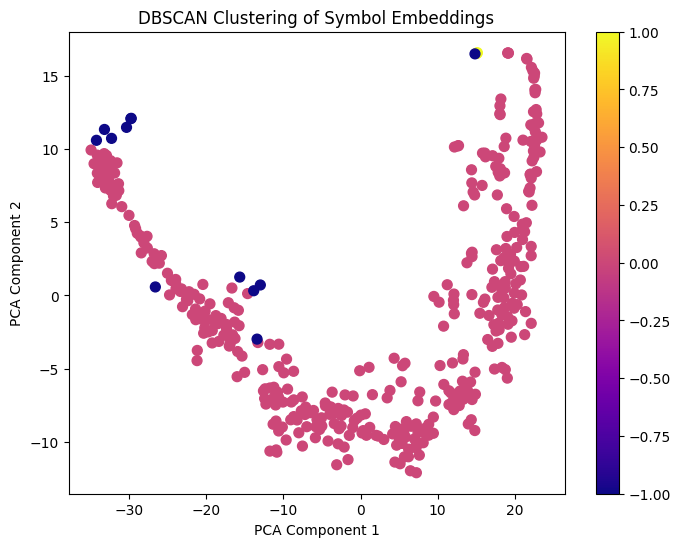

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=dbscan_labels, cmap='plasma', s=50)
plt.colorbar()
plt.title('DBSCAN Clustering of Symbol Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

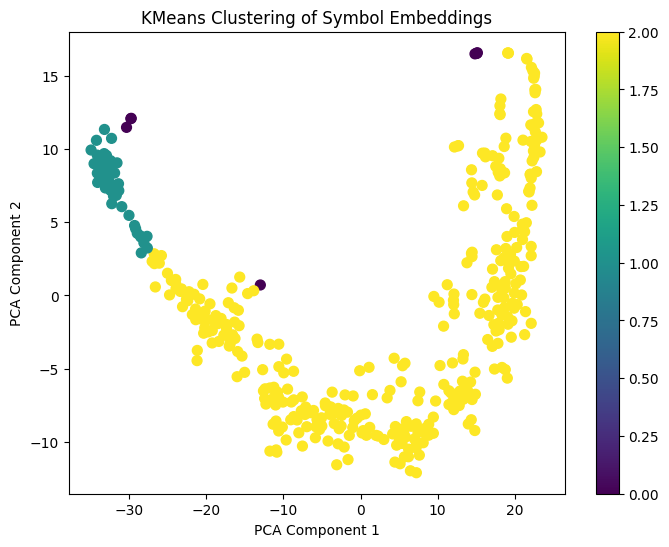

In [78]:
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=k_cluster_labels, cmap='viridis', s=50)
plt.colorbar()
plt.title('KMeans Clustering of Symbol Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()